Here we should make sure that our Transformer implementation works properly. For this purpose we gonna learn to translate on En-De pair

In [1]:
import sys; sys.path += ['..', '../src']

Let's tokenize our sentences (TODO: should we use `moses` for this and not `nltk` because moses can normalize punctuation?)

In [24]:
# %%bash

# cat ../data/multi30k/val.en | \
#     ../ext-libs/mosesdecoder/scripts/tokenizer/normalize-punctuation.perl | \
#     ../ext-libs/mosesdecoder/scripts/tokenizer/tokenizer.perl -threads 1 > \
#     ../data/generated/kek
    
# head ../data/generated/kek

In [31]:
import os

input_data_dir = '../data/multi30k'
output_data_dir = '../data/generated'

if not os.path.exists(output_data_dir): os.mkdir(output_data_dir)

In [28]:
import nltk
nltk.download('punkt')

for file_name in os.listdir(input_data_dir):
    input_file_path = '{}/{}'.format(input_data_dir, file_name)
    output_file_path = '{}/{}.tok'.format(output_data_dir, file_name)
    
    with open(input_file_path, 'r', encoding='utf-8') as file:
        lines = file.read().splitlines()
    
    tokenized = [' '.join(nltk.word_tokenize(line)) for line in lines]
    
    with open(output_file_path, 'w', encoding='utf-8') as file:
        for line in tokenized:
            file.write(line + os.linesep)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/universome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating BPEs (joint for both langs)

In [34]:
%%bash
src="../data/generated/train.en.tok"
trg="../data/generated/train.de.tok"
num_bpes=16000

bpes="../data/generated/bpes"
src_vocab="../data/generated/vocab.en"
trg_vocab="../data/generated/vocab.de"

python ../ext-libs/subword-nmt/learn_joint_bpe_and_vocab.py \
    --input "$src" "$trg" \
    -s "$num_bpes" \
    -o "$bpes" \
    --write-vocabulary "$src_vocab" "$trg_vocab"

# Now we should apply bpe for all our train/test/val files
for file in $(ls ../data/multi30k)
do
    vocab="../data/generated/vocab.${file: -2}"
  
    python ../ext-libs/subword-nmt/apply_bpe.py -c $bpes \
       --vocabulary "$vocab" \
       < "../data/generated/$file.tok" > "../data/generated/$file.tok.bpe"
done

Ok, now we have nice dataset, which we can use for training.
So let's train our Transformer!

In [3]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split() for s in train_src]
train_trg = [s.split() for s in train_trg]
val_src = [s.split() for s in val_src]
val_trg = [s.split() for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]

In [47]:
from importlib import reload
import src.utils.data_utils

reload(src.utils.data_utils)
reload(src.transformer.models)

<module 'src.transformer.models' from '../src/transformer/models.py'>

In [70]:
import tqdm

from src.transformer.models import Transformer

max_len = 50

model = Transformer(
    len(vocab_src),
    len(vocab_trg),
    max_len,
    n_layers=4,
    n_head=4,
    d_word_vec=512,
    d_model=512,
    d_inner_hid=1024,
    d_k=64,
    d_v=64)

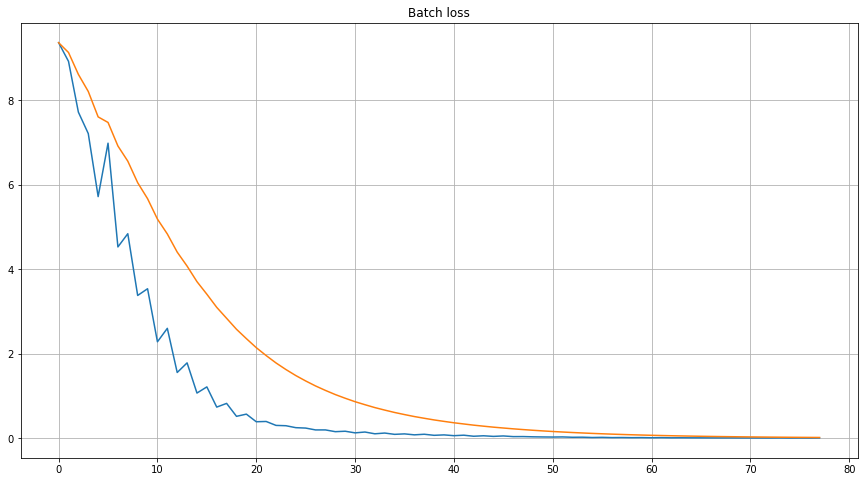

KeyboardInterrupt: 

In [71]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import ewma
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
tqdm.monitor_interval = 0

from src.utils.data_utils import Batcher
import src.transformer.constants as constants


def get_performance(crit, pred, gold):
    loss = crit(pred, gold.contiguous().view(-1))
    pred = pred.max(1)[1]

    gold = gold.contiguous().view(-1)
    n_correct = pred.data.eq(gold.data)
    n_correct = n_correct.masked_select(gold.ne(constants.PAD).data).sum()

    return loss, n_correct


def get_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


optimizer = Adam(model.get_trainable_parameters())
criterion = get_criterion(len(vocab_trg))
training_data = Batcher(train_src_idx[:8], train_trg_idx[:8], vocab_src.token2id, vocab_trg.token2id, batch_size=4)

model.train()
loss_history = []
num_iters_done = 0

for i in range(50):
    for batch in training_data:
        # prepare data
        src, tgt = batch
        gold = tgt[:, 1:]

        # forward
        optimizer.zero_grad()
        pred = model(src, tgt)

        # backward
        loss, n_correct = get_performance(criterion, pred, gold)
        loss.backward()

        # update parameters
        optimizer.step()

        loss_history += [loss.data[0]]
        num_iters_done += 1

        if num_iters_done % 2 == 0:
            clear_output(True)
            plt.figure(figsize=[15,8])
            plt.title("Batch loss")
            plt.plot(loss_history)
            plt.plot(ewma(np.array(loss_history), span=20))
            plt.grid()
            plt.show()

In [72]:
batch = next(training_data)

In [74]:
translations = model.translate_batch(batch[0], max_len=20, beam_size=2)
translations = np.array(translations)

/Users/universome/pyvenvs/zoo/lib/python3.6/site-packages/torch/nn/modules/module.py:325: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self.forward(*input, **kwargs)
100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


In [76]:
for i in range(len(translations)):
    print('Translated:', vocab_trg.remove_bpe(vocab_trg.detokenize(translations[i])))
    print('Real      :', vocab_trg.remove_bpe(vocab_trg.detokenize(batch[1].data[i])))
    print()

Translated: Männer mit Schutzhelmen bedienen ein Antriebsradsystem . . . . . . . ein An@@
Real      : Zwei Männer stehen am Herd und bereiten Essen zu . __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__

Translated: Mann in grün hält eine Gitarre , während der andere Mann sein Hemd ansieht . . . Mann sein Hemd
Real      : Ein Mann in grün hält eine Gitarre , während der andere Mann sein Hemd ansieht .

Translated: Männer mit Schutzhelmen bedienen ein Antriebsradsystem . . . . . . . . .
Real      : Ein Mann lächelt einen ausgestopften Löwen an . __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__

Translated: Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt . . . . . mit dem Handy
Real      : Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt . __PAD__

